In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import os
import json, ast
import math
import scipy.io
import mat4py
from scipy.ndimage import gaussian_filter


In [10]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
cursor_trajectory = []
for participant in participants:
    for block in blocks:
        temp =  scipy.io.loadmat(f'Data/data{participant}/actual_trajectories/trajectories{block}.mat')
        for trial in np.arange(num_trials):
            cursor_trajectory.append(np.array((temp['x'].T[trial][0], temp['y'].T[trial][0])).T.reshape(temp['x'].T[trial][0].shape[1], 2))



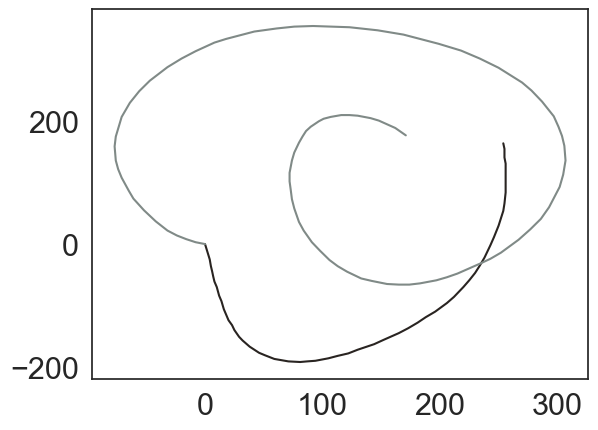

In [27]:
i = 65
plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])
i = 652
plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])


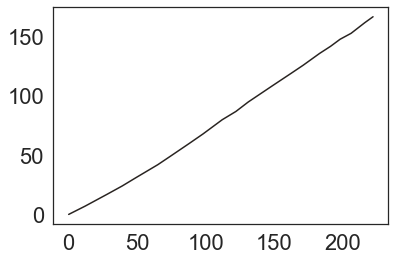

In [281]:
for i in range(i):
    plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])
    # plt.plot(cursor_trajectory[i])

In [42]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                #    'cursor trajectory': np.array(cursor_trajectory, dtype = object)
})

In [160]:
df.to_csv('all_trajectories.csv')

In [78]:
def find_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c

  # cosine_angle = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
  # angle = np.arccos(cosine_angle)
  # signed_angle = np.arctan2(ba[1],ba[0]) - np.arctan2(bc[1],bc[0])

  angles = []
  for v1, v2 in zip(ab, ac):
    dotprod = np.dot(np.abs(v1), np.abs(v2))
    ab_magnitudes = np.linalg.norm(np.abs(v1))
    ac_magnitudes = np.linalg.norm(np.abs(v2))
    crossprod = np.cross(v1, v2)
    if crossprod < 0:
      sign = -1
    else:
      sign = 1

  # # print(dot_products.shape)
  # # Calculate the angles between ab and ac.
    angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))

  return np.nanmean(angles)

def comp_avg_ang_error(traj):
    # try:
    # print(traj)
    traj = traj.astype(float)
    
    end_point = traj[-1]
    curr_point = np.array(traj[:-1])/np.abs(end_point)
    next_point = np.array(traj[1:])/np.abs(end_point)
    
    angles = find_angles(curr_point, end_point, next_point)
    return angles
    # except:
    #     return np.NaN

In [79]:
signed_avg_errors = []
for traj in cursor_trajectory:
    signed_avg_errors.append(comp_avg_ang_error(traj))

C:\Users\tejas\AppData\Local\Temp\ipykernel_13764\4039952039.py:24: RuntimeWarning: invalid value encountered in double_scalars
  angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))
C:\Users\tejas\AppData\Local\Temp\ipykernel_13764\4039952039.py:24: RuntimeWarning: invalid value encountered in arccos
  angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))


In [91]:
df['avg errors'] = np.array(signed_avg_errors)
# df.loc[(df['init signed error'] < 0), 'signed avg errors'] = -df.loc[(df['init signed error'] < 0), 'signed avg errors']
df['avg errors degrees'] = df['avg errors']*180/np.pi


In [99]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))]
df_learn.to_csv('df_learn.csv', index = False)

,p_id,Trial,Block,Rotation,Emphasis,init signed error,init signed error degrees,signed avg errors,signed avg errors degrees,avg errors,avg errors degrees
64,0,64,1,Sudden,Speed,1.753594,100.473528,0.332945,19.076328,0.332945,19.076328
65,0,65,1,Sudden,Speed,2.041179,116.950952,0.660218,37.827702,0.660218,37.827702
66,0,66,1,Sudden,Speed,0.902901,51.732439,0.438751,25.138554,0.438751,25.138554
67,0,67,1,Sudden,Speed,2.159052,123.704559,0.422749,24.221733,0.422749,24.221733
68,0,68,1,Sudden,Speed,0.220566,12.637477,0.586940,33.629189,0.586940,33.629189
...,...,...,...,...,...,...,...,...,...,...,...
46011,59,699,10,Gradual,Accuracy,0.002393,0.137127,0.285975,16.385177,0.285975,16.385177
46012,59,700,10,Gradual,Accuracy,0.245410,14.060975,0.258337,14.801626,0.258337,14.801626
46013,59,701,10,Gradual,Accuracy,0.069254,3.967951,0.363400,20.821281,0.363400,20.821281
46014,59,702,10,Gradual,Accuracy,-0.001036,-0.059338,0.209472,12.001863,0.209472,12.001863


In [44]:
def comp_init_ang_error(traj, proportion=0.1):
    a, b = traj[:, 0]/np.abs(traj[-1, 0]), traj[:, 1]/np.abs(traj[-1, 1])
    cutoff_dist = proportion

    try:
        for cutoff_point in zip(a, b):
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = np.array(cutoff_point) - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        crossprod = np.cross(v1, v2)
        if crossprod < 0:
            sign = -1
        else:
            sign = 1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [46]:
# df_relearn = pd.read_csv('all_trajectories.csv')
errors = []
for traj in cursor_trajectory:
    # print(traj)
    errors.append(comp_init_ang_error(traj))


df['init signed errors'] = np.ravel(errors)
# df.loc[df['Block'] == 11, 'init errors'] = -df.loc[df['Block'] == 11, 'init errors']
# df.loc[df['p_id']%2 == 1, 'Emphasis'] = 'Accuracy'
# df.loc[df['p_id']%2 == 0, 'Emphasis'] = 'Speed'

# df.loc[df['p_id']%4 == 0, 'Rotation'] = 'Sudden'
# df.loc[df['p_id']%4 == 1, 'Rotation'] = 'Sudden'
# df.loc[df['p_id']%4 == 2, 'Rotation'] = 'Gradual'
# df.loc[df['p_id']%4 == 3, 'Rotation'] = 'Gradual'
df['init signed errors degrees'] = df['init signed errors']*180/np.pi



C:\Users\tejas\AppData\Local\Temp\ipykernel_4440\1478270398.py:25: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [ ]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init signed error degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Avg Error (Degrees)')


In [311]:
smoothed = []
for participant in df.p_id.unique():
    for block in range(12):
        temp = df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'].values
        df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'] = np.nan_to_num(temp, nan = np.nanmedian(temp))
        smoothed.append(gaussian_filter(df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'].values, sigma=2))

smoothed = np.ravel(smoothed)

df['smoothed avg error'] = smoothed
df['smoothed avg error degrees'] = df['smoothed avg error']*180/np.pi
# df = df.drop('cursor trajectory', axis = 1)

In [313]:
def clean_data(df):
    # Replace gaps forward from the previous valid value in: 'avg errors', 'avg errors degrees' and 2 other columns
    df = df.fillna({'avg errors': df['smoothed avg error'].ffill(), 'avg errors degrees': df['avg errors degrees'].ffill(), 'smoothed avg error': df['smoothed avg error'].ffill(), 'smoothed avg error degrees': df['smoothed avg error degrees'].ffill()})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,p_id,Trial,Block,Rotation,Emphasis,avg errors,avg errors degrees,smoothed avg error,smoothed avg error degrees
0,0,0,0,Sudden,Speed,0.087757,0.087757,0.114167,6.541259
1,0,1,0,Sudden,Speed,0.109257,0.109257,0.111866,6.409433
2,0,2,0,Sudden,Speed,0.229315,0.229315,0.104513,5.988174
3,0,3,0,Sudden,Speed,0.044903,0.229315,0.091834,5.261720
4,0,4,0,Sudden,Speed,0.041478,0.041478,0.078135,4.476785


In [328]:
df = df.drop('cursor trajectory', axis = 1)

In [330]:
df.to_csv('df_allphases.csv')

In [77]:
df

,p_id,Trial,Block,Rotation,Emphasis,init signed error,init signed error degrees,signed avg errors,signed avg errors degrees
0,0,0,0,Sudden,Speed,0.140367,8.042440,-0.085617,-4.905479
1,0,1,0,Sudden,Speed,-0.037216,-2.132311,0.037203,2.131555
2,0,2,0,Sudden,Speed,-0.048070,-2.754213,0.081677,4.679736
3,0,3,0,Sudden,Speed,-0.059439,-3.405619,0.114367,6.552725
4,0,4,0,Sudden,Speed,-0.034114,-1.954605,0.141878,8.129014
...,...,...,...,...,...,...,...,...,...
46075,59,763,11,Gradual,Accuracy,-0.363901,-20.850013,-0.022899,-1.311991
46076,59,764,11,Gradual,Accuracy,-0.412636,-23.642282,0.052473,3.006491
46077,59,765,11,Gradual,Accuracy,-0.800991,-45.893385,0.036415,2.086450
46078,59,766,11,Gradual,Accuracy,-0.491390,-28.154572,0.059765,3.424297


In [334]:
df_learn = df.loc[df['Block'] < 11].reset_index().drop('index', axis = 1)
df_washout = df.loc[df['Block'] == 11].reset_index().drop('index', axis = 1)
df_washout['Trial'] = np.tile(np.arange(64), 60)
df_learn.to_csv('df_learn.csv')
df_washout.to_csv('df_washout.csv')

In [50]:
# df_allphases = pd.read_csv('df_allphases.csv')

,Unnamed: 0,p_id,Trial,Block,Rotation,Emphasis,init errors,init errors degrees
0,0,0,0,0,Sudden,Speed,0.140367,8.042440
1,1,0,1,0,Sudden,Speed,0.037216,2.132311
2,2,0,2,0,Sudden,Speed,0.048070,2.754213
3,3,0,3,0,Sudden,Speed,0.059439,3.405619
4,4,0,4,0,Sudden,Speed,0.034114,1.954605
...,...,...,...,...,...,...,...,...
46075,46075,59,763,11,Gradual,Accuracy,-0.363901,-20.850013
46076,46076,59,764,11,Gradual,Accuracy,-0.412636,-23.642282
46077,46077,59,765,11,Gradual,Accuracy,-0.800991,-45.893385
46078,46078,59,766,11,Gradual,Accuracy,-0.491390,-28.154572


In [45]:
# df['avg errors smooth'] = 
df_learn_signed = pd.read_csv('df_learn_signed.csv')
smoothed = []
for participant in range(60):
    for block in range(1, 11):
        smoothed.append(gaussian_filter(df_learn_signed.loc[((df_learn_signed['p_id'] == participant) & (df_learn_signed['Block'] == block)), 'init signed error'].values, sigma = 2))
df_learn_signed['init signed smooth'] = np.ravel(smoothed)

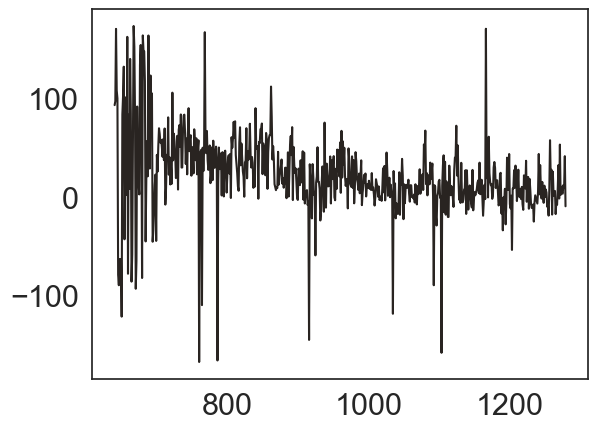

In [41]:
plt.plot(df_learn_signed.loc[640:640*2, 'init signed error degrees'])

In [47]:
df_learn_signed_smooth = df_learn_signed.copy()
df_learn_signed_smooth.to_csv('df_laern_signed_smooth.csv', index = False)

In [7]:
df_learn_signed = pd.read_csv('df_learn_signed.csv')
# df_learn_signed

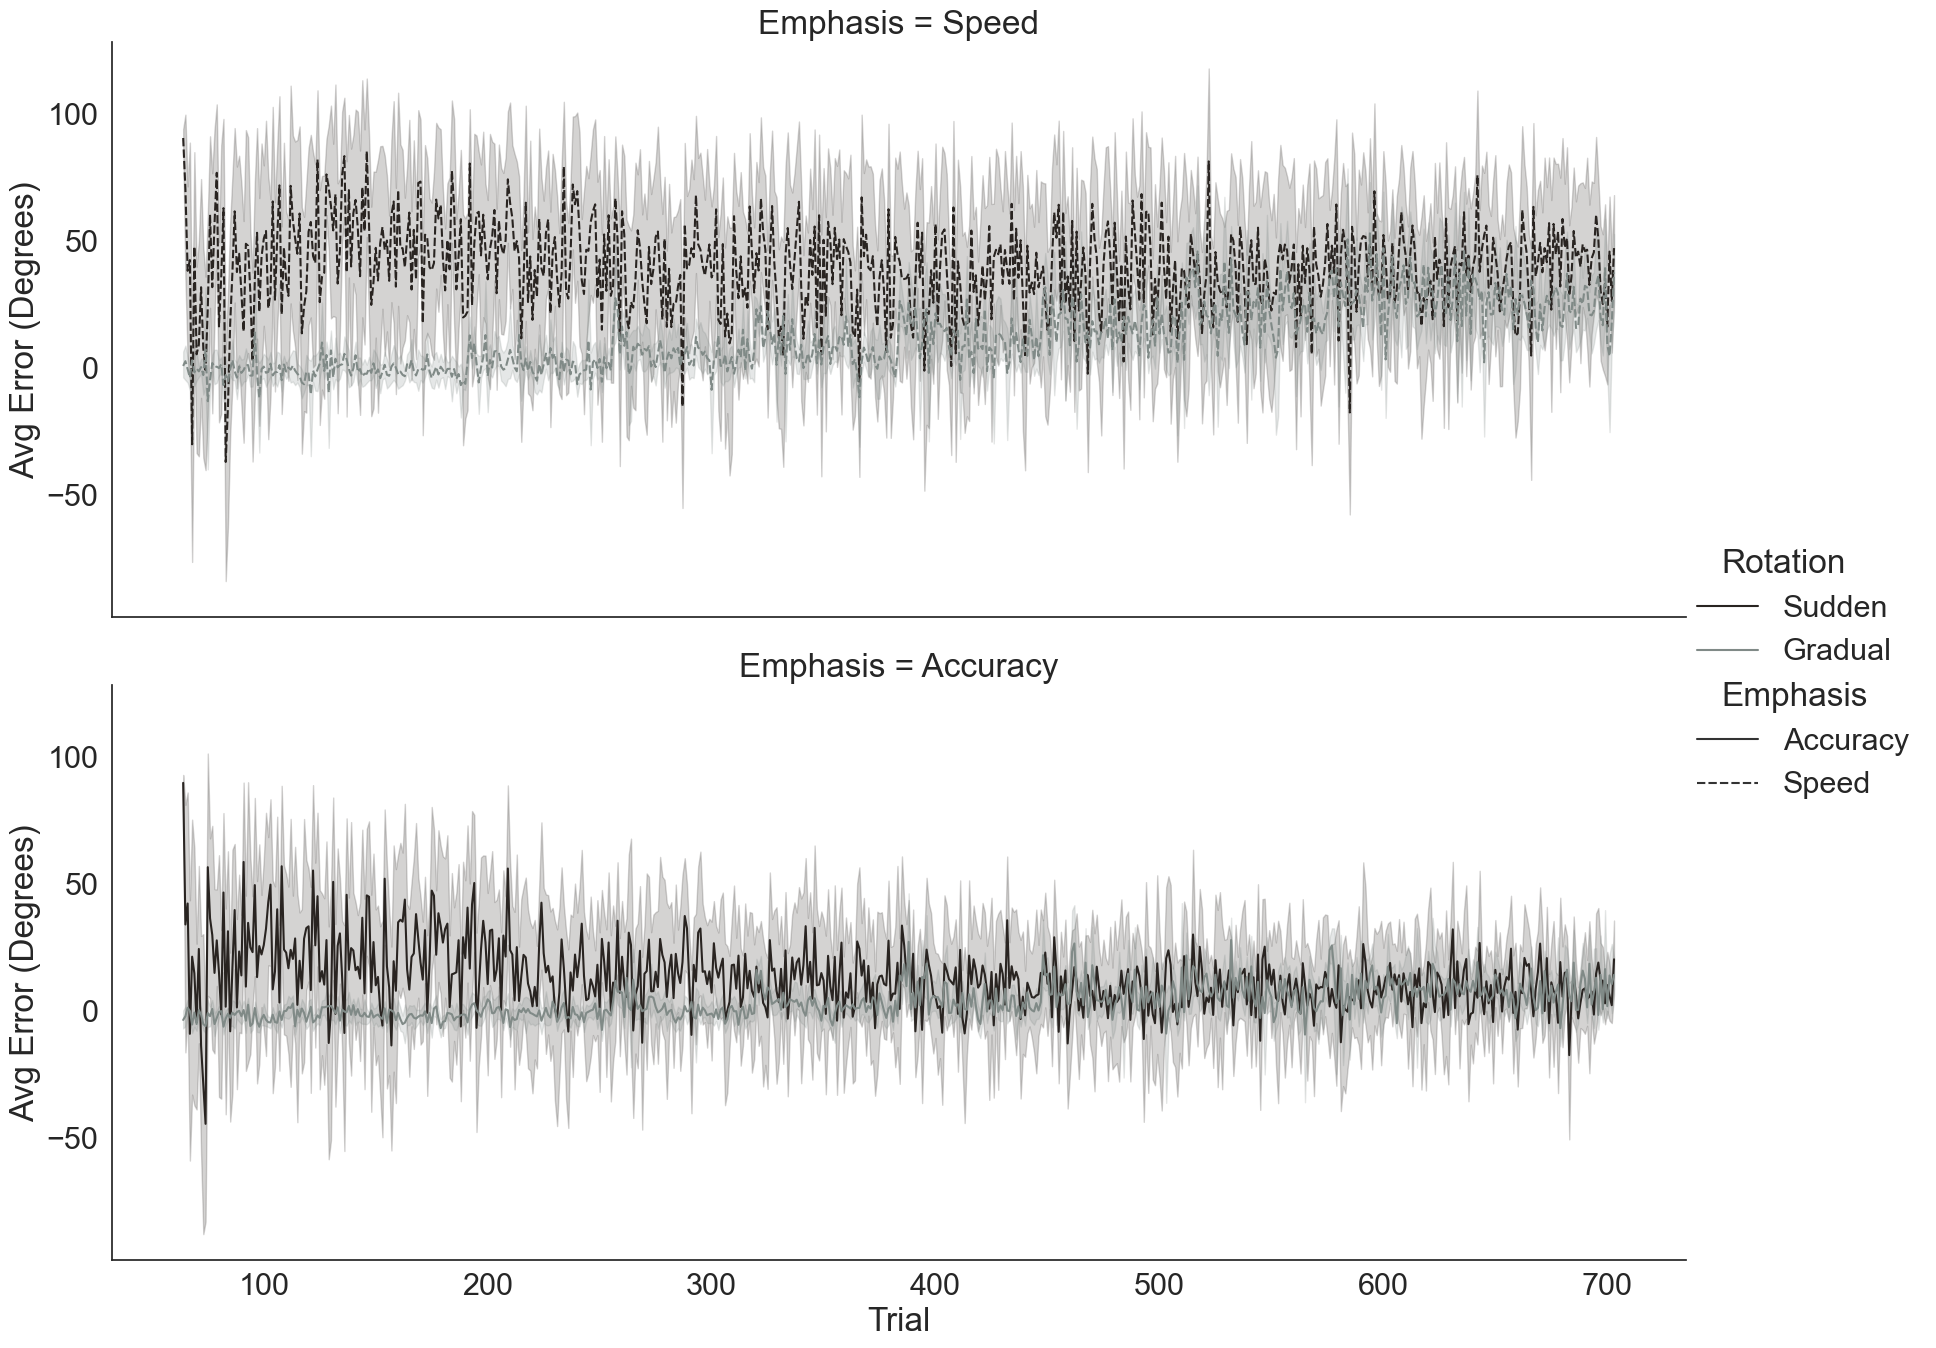

In [48]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init signed error degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df_learn_signed, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Avg Error (Degrees)')

# draw lines:
# for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*8, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*9, ymax=100, ymin = -100, color = 'black', linestyles = '--')

#     ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

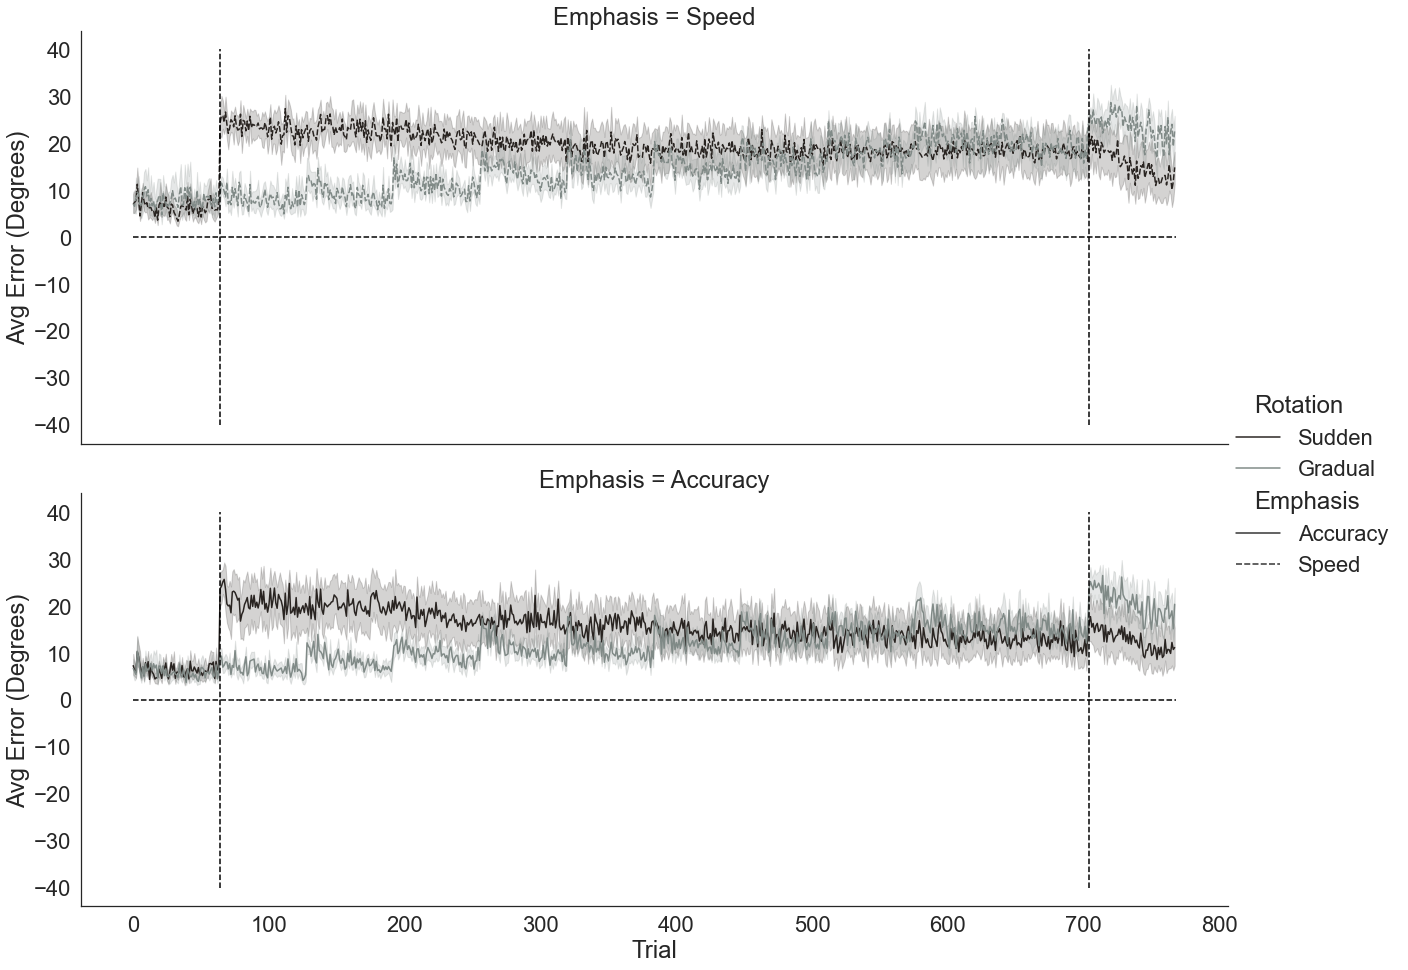

In [100]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'avg errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Avg Error (Degrees)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=40, ymin = -40, color = 'black', linestyles = '--')
    ax.vlines(x = 64*11, ymax=40, ymin = -40, color = 'black', linestyles = '--')

    ax.hlines(y=0, xmin = 0, xmax = 768, color = 'black', linestyles = '--')

In [79]:
df = df.drop('cursor trajectory', axis = 1)
df.to_csv('df_allphases.csv')


In [86]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))].reset_index().drop('index', axis = 1)
df_learn.to_csv('df_learn.csv')

In [91]:
df_blockwise = pd.read_csv('df_blockwise.csv')

In [ ]:
df_allphases = pd.read_csv('df_allphases.csv')

In [103]:
df_learnwashout = df.loc[((df['Block'] > 0))].reset_index().drop('index', axis = 1)


In [105]:
df_learnwashout.to_csv('df_learnwashout.csv', index = False)

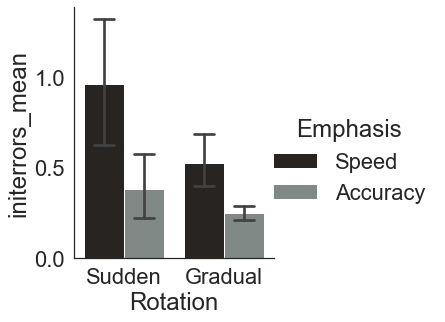

In [95]:
sns.catplot(y = 'initerrors_mean', x = 'Rotation', hue = 'Emphasis', 
            data = df_blockwise.loc[((df_blockwise['Block'] == 10))], 
            kind = 'bar', capsize = 0.2)

In [ ]:
df_allphases_blockwise['difference'] = df_allphases_blockwise['initerrors_mean'].diff(periods= 2)

In [ ]:
g = sns.catplot(y = 'difference', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['block no'] == 8))], 
            kind = 'bar', capsize = 0.2)
g.set_ylabels('Error Difference \n Relearning - Learning')


In [3]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
cursor_trajectory = []
for participant in participants:
    for block in blocks:
        temp =  scipy.io.loadmat(f'Data/data{participant}/actual_trajectories/trajectories{block}.mat')
        for trial in np.arange(num_trials):
            cursor_trajectory.append(np.array((temp['x'].T[trial][0], temp['y'].T[trial][0])).T.reshape(temp['x'].T[trial][0].shape[1], 2))


def comp_init_ang_error(traj, proportion=0.1):
    a, b = traj[:, 0]/np.abs(traj[-1, 0]), traj[:, 1]/np.abs(traj[-1, 1])
    cutoff_dist = proportion

    try:
        for cutoff_point in zip(a, b):
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = np.array(cutoff_point) - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        cross = np.cross(v1, v2)
        if cross > 0:
            sign = -1
        else:
            sign = 1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [4]:
init_signed_error = []
for traj in cursor_trajectory:
    init_signed_error.append(comp_init_ang_error(traj))

C:\Users\tejas\AppData\Local\Temp\ipykernel_13764\1865050589.py:38: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [9]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                    'init signed error': np.array(init_signed_error),
                    'init signed error degrees': np.array(init_signed_error)*180/np.pi,

                   
})

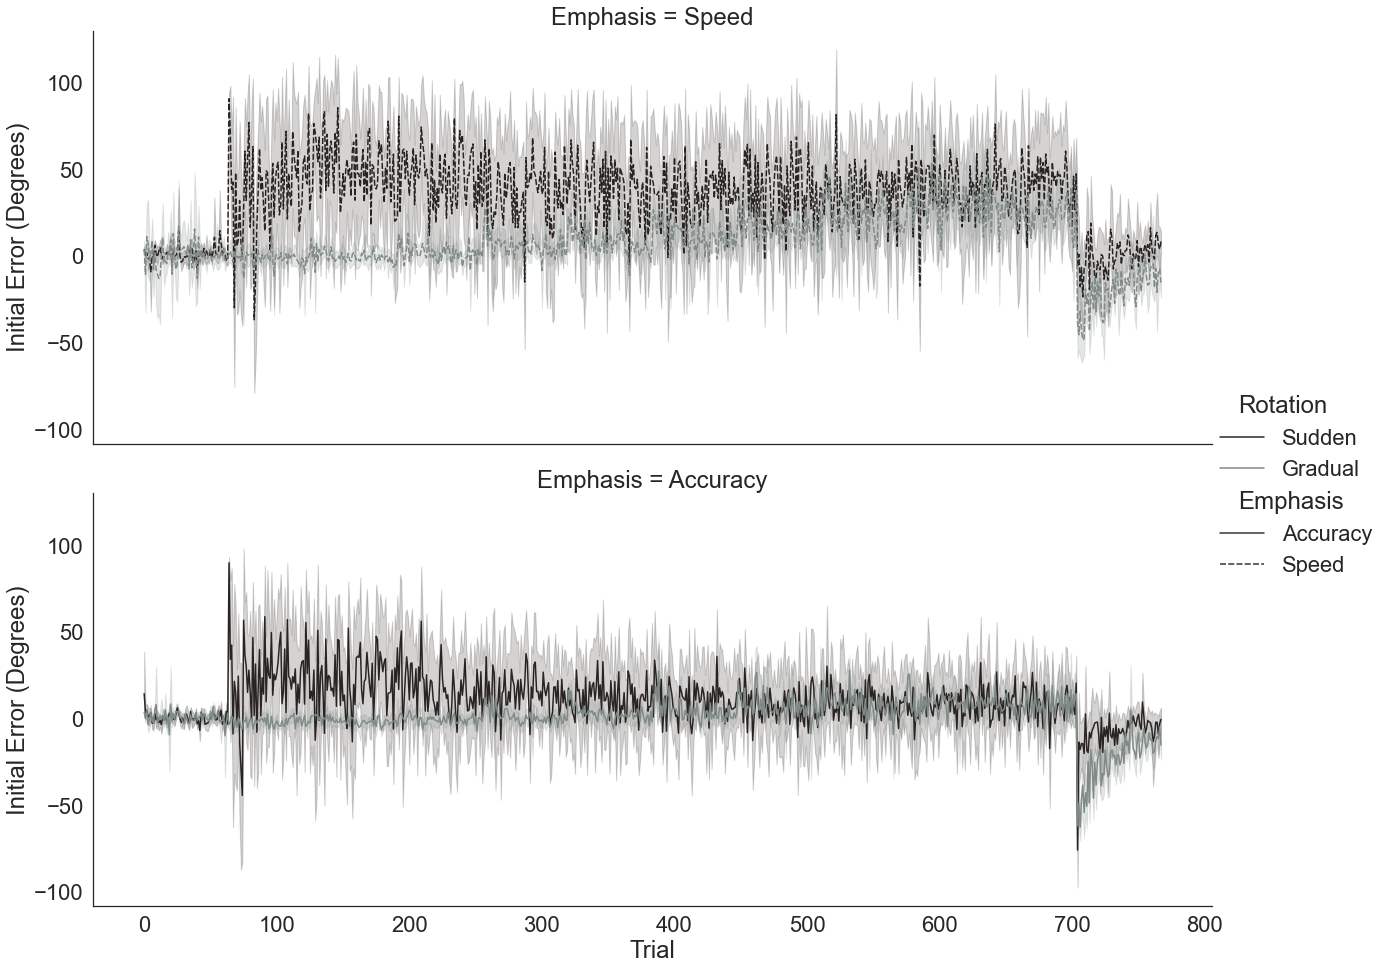

In [31]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init signed error degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Initial Error (Degrees)')


In [12]:
def blockwise_data(df):
    # Performed 2 aggregations grouped on columns: 'p_id', 'Block' and 2 other columns
    df = df.groupby(['p_id', 'Block', 'Rotation', 'Emphasis']).agg(initsignederror_mean=('init signed error', 'mean'), initsignederrordegrees_mean=('init signed error degrees', 'mean')).reset_index()
    return df

df_blockwise = blockwise_data(df.copy())


In [36]:
np.mean(df_blockwise.loc[((df_blockwise['Rotation'] == 'Sudden') & (df_blockwise['Emphasis'] == 'Speed') & (df_blockwise['Block'] == 11)), 'initsignederrordegrees_mean'])

0.06903372848374924

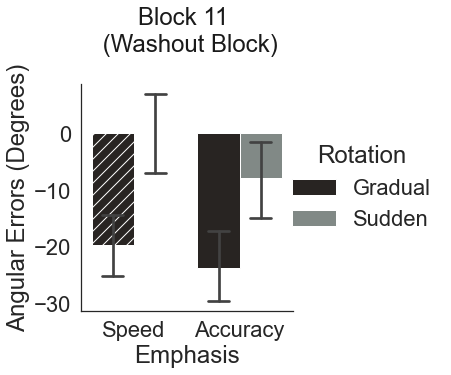

In [38]:
# df_blockwise['initerrors_mean_degrees'] = df_blockwise['initerrors_mean']*180/np.pi
g = sns.catplot(x = 'Emphasis', hue = 'Rotation', y = 'initsignederrordegrees_mean', col = 'Block',
            data = df_blockwise.loc[((df_blockwise['Block']==11))],
            kind = 'bar', capsize = 0.2, hue_order=['Gradual', 'Sudden'] 
            )
x1, x2 = 0, 1
y, h, col = df_blockwise.loc[(df_blockwise['Block'] == 11)]['initsignederrordegrees_mean'].max()-35, 0.02, 'k'
plt.text(0.5, y+h+25, "Block 11 \n (Washout Block)", ha='center', va='bottom', color=col)
# plt.text(0.5, y+h+5, "*", ha='center', va='bottom', color=col)
# plt.axhline(y=y+h+10, xmin=0.25, xmax=0.75, color = 'black')
# plt.text(0, y+h, "*", ha='center', va='bottom', color=col)
# plt.axhline(y=y+h+5, xmin=0.125, xmax=0.375, color = 'black')
# plt.text(1, y+h, "*", ha='center', va='bottom', color=col)
# plt.axhline(y=y+h+5, xmin=0.625, xmax=0.875, color = 'black')

g.set(ylabel='Angular Errors (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [21]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))].reset_index().drop('index', axis = 1)
df_learn.to_csv('df_learn_signed.csv') 
#Used data wrangler to fill missing values and resaved it.

In [30]:
df_learn_washout = df.loc[(df['Block'] > 0)].reset_index().drop('index', axis = 1)
df_learn_washout.to_csv('df_learnwashout_signed.csv', index = False)
#Used data wrangler to fill missing values and resaved it.
# df_learn_washout

,p_id,Trial,Block,Rotation,Emphasis,init signed error,init signed error degrees
0,0,64,1,Sudden,Speed,1.753594,100.473528
1,0,65,1,Sudden,Speed,2.041179,116.950952
2,0,66,1,Sudden,Speed,0.902901,51.732439
3,0,67,1,Sudden,Speed,2.159052,123.704559
4,0,68,1,Sudden,Speed,0.220566,12.637477
...,...,...,...,...,...,...,...
42235,59,763,11,Gradual,Accuracy,-0.363901,-20.850013
42236,59,764,11,Gradual,Accuracy,-0.412636,-23.642282
42237,59,765,11,Gradual,Accuracy,-0.800991,-45.893385
42238,59,766,11,Gradual,Accuracy,-0.491390,-28.154572
